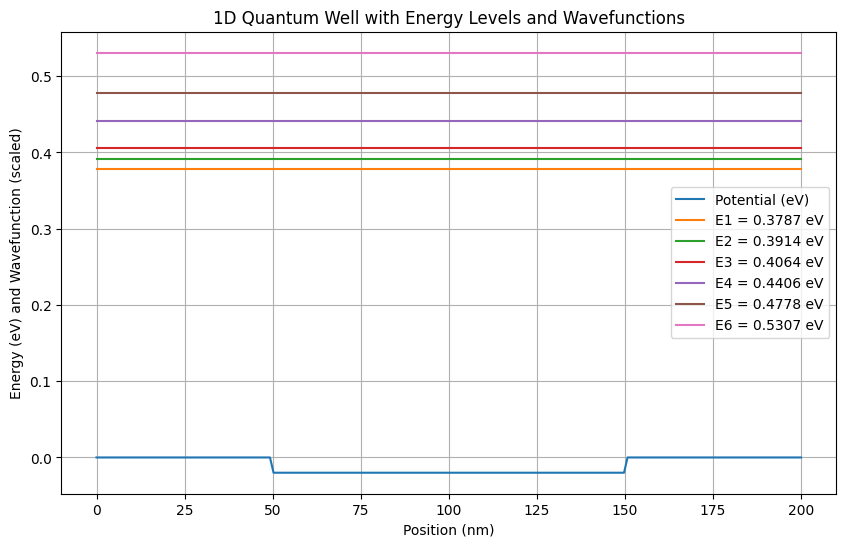

In [11]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

# 1. Define the spatial grid (1D example)
nx = 200
x = np.linspace(0, 200e-9, nx)  # 200 nm length

# 2. Define material properties (simplified)
def get_epsilon(x):
    """Simplified dielectric constant profile (assuming uniform for now)."""
    epsilon_si = 11.7 * 8.854e-12
    return np.full_like(x, epsilon_si)

def get_effective_mass(x):
    """Simplified effective mass profile (assuming uniform for electrons)."""
    m_e_si = 0.19 * 9.109e-31  # Longitudinal effective mass of electrons in Si
    return np.full_like(x, m_e_si)

# 3. Define charge density (initially zero)
rho = np.zeros(nx)

# 4. Define boundary conditions for Poisson's equation (potential at the ends)
phi_boundary = np.array([0.0, 0.0])  # Assume grounded contacts at both ends

# 5. Discretize and solve Poisson's equation (1D finite difference)
def solve_poisson_1d(x, rho, phi_boundary):
    n = len(x)
    dx = x[1] - x[0]
    A = scipy.sparse.diags([1, -2, 1], [-1, 0, 1], shape=(n, n)) / (dx**2)
    b = rho / get_epsilon(x)

    # Apply Dirichlet boundary conditions
    A[0, 0] = 1
    A[0, 1] = 0
    b[0] = phi_boundary[0]

    A[n - 1, n - 2] = 0
    A[n - 1, n - 1] = 1
    b[n - 1] = phi_boundary[1]

    phi, info = scipy.sparse.linalg.cg(A, b, tol=1e-9, maxiter=500)
    return phi

# 6. Discretize and solve Schrödinger equation (1D finite difference)
def solve_schrodinger_1d(x, V, m_eff, num_eigenvalues=6):
    n = len(x)
    dx = x[1] - x[0]
    hbar = 1.0545718e-34

    main_diag = np.ones(n) * (hbar**2) / (m_eff * dx**2) * 2 + V
    off_diag = np.ones(n - 1) * (-0.5 * hbar**2) / (m_eff[:-1] * dx**2)

    H = scipy.sparse.diags([off_diag, main_diag, off_diag], [-1, 0, 1], shape=(n, n))

    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(H, k=num_eigenvalues, which='SM', tol=1e-9)
    return eigenvalues, eigenvectors

# 7. Define a simple potential well (representing a quantum well)
def define_potential_well(x):
    V = np.zeros_like(x)
    well_start = 50e-9
    well_end = 150e-9
    well_depth = -0.02 * 1.602e-19  # Example potential depth in Joules
    V[(x >= well_start) & (x <= well_end)] = well_depth
    return V

# 8. Main simulation loop (without self-consistency for this basic example)
potential = define_potential_well(x)
effective_mass = get_effective_mass(x)

eigenvalues, eigenvectors = solve_schrodinger_1d(x, potential, effective_mass)

# 9. Visualization
plt.figure(figsize=(10, 6))
plt.plot(x * 1e9, potential / 1.602e-19, label='Potential (eV)')
for i in range(len(eigenvalues)):
    # Scale eigenvectors for visualization
    scaled_eigenvector = eigenvectors[:, i] * 1e-7 + eigenvalues[i] / 1.602e-19
    plt.plot(x * 1e9, scaled_eigenvector, label=f'E{i+1} = {eigenvalues[i]/1.602e-19:.4f} eV')

plt.xlabel('Position (nm)')
plt.ylabel('Energy (eV) and Wavefunction (scaled)')
plt.title('1D Quantum Well with Energy Levels and Wavefunctions')
plt.legend()
plt.grid(True)
plt.show()

# Next steps would involve:
# - Implementing the effect of gate voltages on the potential (for overlapping gates, this would be in 2D or 3D).
# - Implementing the self-consistent loop between Poisson and Schrödinger solvers.
# - Extending to 2D or 3D.
# - Modeling the Si/SiGe heterostructure with band offsets in the potential.

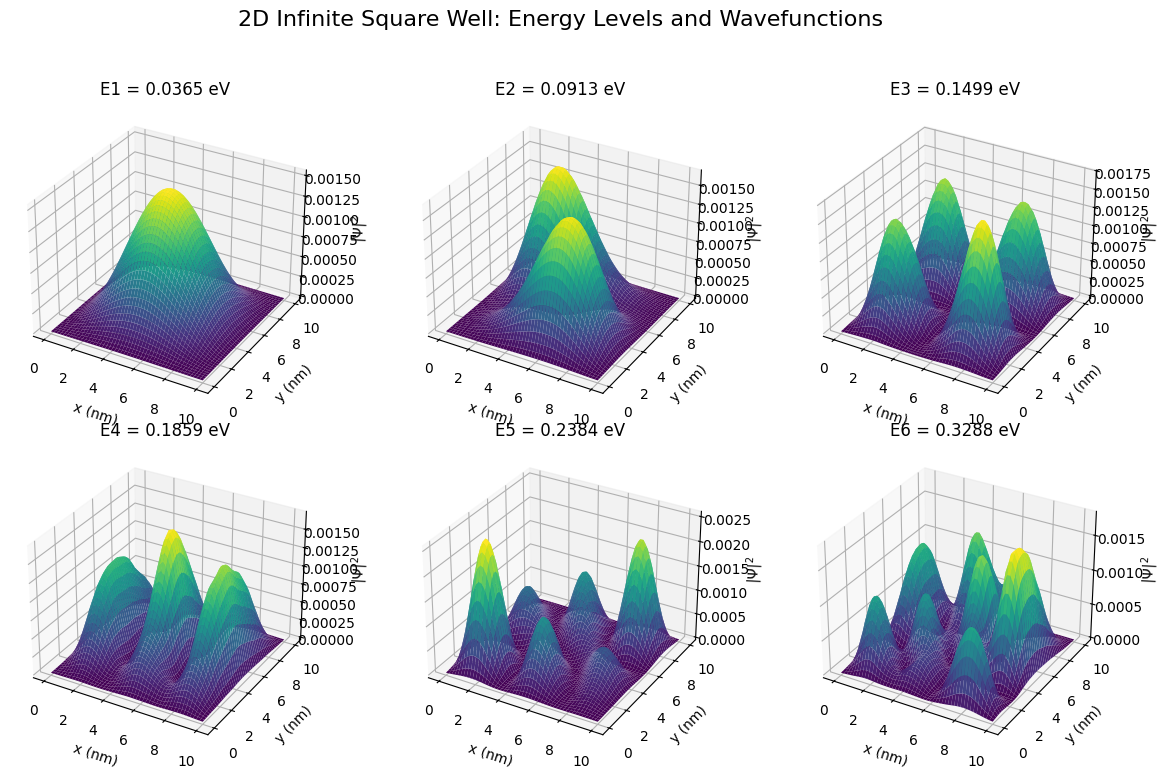

In [12]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def solve_schrodinger_2d(x, y, V, m_eff, num_eigenvalues=6):
    """Solves the 2D time-independent Schrödinger equation using finite difference."""
    nx = len(x)
    ny = len(y)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    hbar = 1.0545718e-34

    # Create a flattened index mapping
    def idx(i, j):
        return j * nx + i

    # Construct the Hamiltonian matrix
    H = scipy.sparse.lil_matrix((nx * ny, nx * ny), dtype=np.complex128)

    for i in range(nx):
        for j in range(ny):
            # Diagonal element (kinetic + potential)
            H[idx(i, j), idx(i, j)] += (hbar**2 / (2 * m_eff)) * (2 / dx**2 + 2 / dy**2) + V[j, i]

            # Off-diagonal elements (x-direction)
            if i > 0:
                H[idx(i, j), idx(i - 1, j)] -= (hbar**2 / (2 * m_eff)) * (1 / dx**2)
            if i < nx - 1:
                H[idx(i, j), idx(i + 1, j)] -= (hbar**2 / (2 * m_eff)) * (1 / dx**2)

            # Off-diagonal elements (y-direction)
            if j > 0:
                H[idx(i, j), idx(i, j - 1)] -= (hbar**2 / (2 * m_eff)) * (1 / dy**2)
            if j < ny - 1:
                H[idx(i, j), idx(i, j + 1)] -= (hbar**2 / (2 * m_eff)) * (1 / dy**2)

    # Solve for eigenvalues and eigenvectors
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(H.tocsc(), k=num_eigenvalues, which='SM', tol=1e-9)

    # Reshape eigenvectors to 2D arrays
    eigenfunctions = np.array([eigenvectors[:, i].reshape((ny, nx)) for i in range(num_eigenvalues)])

    return eigenvalues, eigenfunctions

# 1. Define the 2D spatial grid
nx = 50
ny = 50
x = np.linspace(0, 10e-9, nx)
y = np.linspace(0, 10e-9, ny)
X, Y = np.meshgrid(x, y)

# 2. Define the potential (2D infinite square well)
V = np.zeros((ny, nx))

# 3. Define effective mass (constant for now)
m_eff = 0.19 * 9.109e-31

# 4. Solve the 2D Schrödinger equation
eigenvalues, eigenfunctions = solve_schrodinger_2d(x, y, V, m_eff)

# 5. Visualization
fig = plt.figure(figsize=(12, 8))
fig.suptitle('2D Infinite Square Well: Energy Levels and Wavefunctions', fontsize=16)

for i in range(len(eigenvalues)):
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    ax.plot_surface(X * 1e9, Y * 1e9, np.abs(eigenfunctions[i])**2, cmap='viridis')
    ax.set_title(f'E{i+1} = {eigenvalues[i]/1.602e-19:.4f} eV')
    ax.set_xlabel('x (nm)')
    ax.set_ylabel('y (nm)')
    ax.set_zlabel('$|\Psi|^2$')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the computational domain and create a mesh
domain_width = 20e-9
domain_height = 10e-9
gate_width = 10e-9
gate_y_start = 0  # Top gate
gate_y_end = 1e-9
gate_x_start = (domain_width - gate_width) / 2
gate_x_end = gate_x_start + gate_width

mesh = RectangleMesh(MPI.COMM_WORLD, Point(0, 0), Point(domain_width, domain_height), 50, 25)

# 2. Mark subdomains for materials and boundaries
class SubDomainSiGe(SubDomain):
    def inside(self, x):
        return x[1] > 2e-9 - DOLFIN_EPS  # Example SiGe layer

class SubDomainSi(SubDomain):
    def inside(self, x):
        return x[1] <= 2e-9 + DOLFIN_EPS  # Example Si layer

class BoundaryGate(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and np.isclose(x[0], gate_x_start) and np.isclose(x[1], gate_y_start) or \
               on_boundary and np.isclose(x[0], gate_x_end) and np.isclose(x[1], gate_y_start) or \
               on_boundary and gate_x_start - DOLFIN_EPS <= x[0] <= gate_x_end + DOLFIN_EPS and \
               np.isclose(x[1], gate_y_end)

class BoundaryBottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and np.isclose(x[1], 0)

# Initialize subdomains and mark them
subdomain_sige = SubDomainSiGe()
subdomain_si = SubDomainSi()
boundary_gate = BoundaryGate()
boundary_bottom = BoundaryBottom()

materials = MeshTags(mesh, mesh.topology.cell_entity_types[-1], np.zeros(mesh.num_cells, dtype=np.int32))
for cell in locate_entities_global(mesh, mesh.topology.cell_entity_types[-1], subdomain_si):
    materials.values[cell] = 1  # Mark Si region as 1

facet_tags = MeshTags(mesh, mesh.topology.dim - 1, np.zeros(mesh.num_facets, dtype=np.int32))
for facet in locate_entities_boundary(mesh, facet_tags.dim, boundary_gate):
    facet_tags.values[facet] = 1  # Mark gate boundary as 1
for facet in locate_entities_boundary(mesh, facet_tags.dim, boundary_bottom):
    facet_tags.values[facet] = 2  # Mark bottom boundary as 2

# 3. Define the function space for the potential
V = FiniteElement("P", mesh.ufl_cell(), 1)
W = FunctionSpace(mesh, V)

# 4. Define the permittivity as a function of material
epsilon_si = 11.7 * 8.854e-12
epsilon_sige = 13.0 * 8.854e-12
epsilon_r = Function(W)
for cell in cells(mesh):
    material_id = materials.values[cell.index]
    if material_id == 1:
        epsilon_r.vector.array[cell.index] = epsilon_si
    else:
        epsilon_r.vector.array[cell.index] = epsilon_sige
epsilon = epsilon_r

# 5. Define boundary conditions
gate_voltage = 1.0  # Applied gate voltage
ground_voltage = 0.0 # Ground at the bottom

facets_gate = facet_tags.find(1)
bc_gate = dirichletbc(ScalarType(gate_voltage), W, facets_gate)
facets_bottom = facet_tags.find(2)
bc_ground = dirichletbc(ScalarType(ground_voltage), W, facets_bottom)
bcs = [bc_gate, bc_ground]

# 6. Define the variational problem for Poisson's equation (without charge density for now)
u = TrialFunction(W)
v = TestFunction(W)
f = Constant(mesh, ScalarType(0.0))  # No free charge

a = inner(epsilon * grad(u), grad(v)) * dx
L = f * v * dx

# 7. Solve the variational problem
phi = Function(W)
solve(a == L, phi, bcs=bcs)

# 8. Plot the potential
fig, ax = plt.subplots()
c = plot(phi, ax=ax)
fig.colorbar(c, label="Potential (V)")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("Electrostatic Potential (with Top Gate - FEniCSx)")
plt.show()

ModuleNotFoundError: No module named 'fenics'

In [10]:
import devsim
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the device geometry and create a 2D mesh
device = "device2d"
mesh = "mesh2d"
x_min, x_max = 0, 20e-9
y_min, y_max = 0, 10e-9
nx = 50
ny = 25
devsim.create_2d_mesh(mesh=mesh,
                       x_min=x_min, x_max=x_max, nx=nx,
                       y_min=y_min, y_max=y_max, ny=ny)

# 2. Define regions and materials
devsim.add_region(device=device, region="SiGe", material="SiGe",
                  mesh=mesh, y_min=2e-9)
devsim.add_region(device=device, region="Si", material="Si",
                  mesh=mesh, y_max=2e-9)

# 3. Define contacts (gates)
gate_x_start = (20e-9 - 10e-9) / 2
gate_x_end = gate_x_start + 10e-9
gate_y = 0

devsim.add_contact(device=device, name="top_gate",
                   geometry="2d", y=gate_y,
                   x_min=gate_x_start, x_max=gate_x_end)
devsim.set_contact_bias(device=device, name="top_gate", voltage=1.0)

devsim.add_contact(device=device, name="bottom",
                   geometry="2d", y=0,
                   x_min=0, x_max=20e-9)
devsim.set_contact_bias(device=device, name="bottom", voltage=0.0)

# 4. Set material parameters (permittivity)
epsilon_si = 11.7 * 8.854e-12
epsilon_sige = 13.0 * 8.854e-12

devsim.set_material(device=device, region="Si", parameter="Permittivity", value=epsilon_si)
devsim.set_material(device=device, region="SiGe", parameter="Permittivity", value=epsilon_sige)

# 5. Define the equation to solve (Poisson's equation)
devsim.add_equation(device=device, name="potential_equation",
                    region="Si", variable_name="Potential",
                    equation="epsilon() * laplacian(Potential) = 0")
devsim.add_equation(device=device, name="potential_equation",
                    region="SiGe", variable_name="Potential",
                    equation="epsilon() * laplacian(Potential) = 0")

# 6. Solve the system
devsim.solve(device=device, type="dc", solver="cg", absolute_error=1e-9, relative_error=1e-9, iterations=50)

# 7. Extract the potential
potential = devsim.get_element_node_values(device=device, region="Si", name="Potential")
x_coords_result = devsim.get_2d_mesh_coordinates(device=device, region="Si")["x"]
y_coords_result = devsim.get_2d_mesh_coordinates(device=device, region="Si")["y"]
nx_result = len(np.unique(x_coords_result))
ny_result = len(np.unique(y_coords_result))
potential_map = np.reshape(potential, (ny_result, nx_result))
x_unique = np.unique(x_coords_result) * 1e9
y_unique = np.unique(y_coords_result) * 1e9
X, Y = np.meshgrid(x_unique, y_unique)

# 8. Visualize the potential
plt.figure()
plt.imshow(potential_map, extent=[X.min(), X.max(), Y.min(), Y.max()], origin='lower', aspect='auto')
plt.colorbar(label='Potential (V)')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.title('Electrostatic Potential (with Top Gate - DEVSIM)')
plt.show()

# Clean up the device (optional)
devsim.delete_device(device=device)

error: nx is an invalid option
